# Walkthrough for using the Fast Stylometry model for Burrows' Delta

You can run this notebook in Google Colab: <a href="https://colab.research.google.com/github/fastdatascience/faststylometry/blob/main/Burrows%20Delta%20Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Thomas Wood](https://freelancedatascientist.net), [Fast Data Science](https://fastdatascience.com)

Burrows' Delta is an algorithm for comparing the similarity of the writing styles of documents, known as [forensic stylometry](https://fastdatascience.com/how-you-can-identify-the-author-of-a-document/).

* [A useful explanation of the maths and thinking behind Burrows' Delta and how it works](https://programminghistorian.org/en/lessons/introduction-to-stylometry-with-python#third-stylometric-test-john-burrows-delta-method-advanced)

Demonstration of Burrows' Delta on a small corpus downloaded from Project Gutenberg.

We will test the Burrows' Delta code on two "unknown" texts: Sense and Sensibility by Jane Austen, and Villette by Charlotte Bronte. Both authors are in our training corpus.

This notebook demonstrates how to use the library to calculate the Burrows' Delta value of six candidate authors, and also to calculate the probability that each one is the author of the mystery text.


You can also read the [tutorial](https://fastdatascience.com/fast-stylometry-python-library/) or try out the [live demo of the tool](https://fastdatascience.com/forensic-stylometry-linguistics-authorship-analysis-demo/).

## First install the library

In [3]:
!python --version

Python 3.12.7


In [7]:
!pip install faststylometry==1.0.13

  Attempting uninstall: faststylometry
    Found existing installation: faststylometry 1.0.11
    Uninstalling faststylometry-1.0.11:
      Successfully uninstalled faststylometry-1.0.11


In [9]:
from faststylometry import Corpus

from faststylometry import download_examples
from faststylometry import load_corpus_from_folder
from faststylometry import tokenise_remove_pronouns_en
from faststylometry import calculate_burrows_delta
from faststylometry import predict_proba, calibrate, get_calibration_curve


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/thomas/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/thomas/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/thomas/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/home/thoma

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import

Download the example corpus (Project Gutenberg texts) from the internet

In [4]:
download_examples()

NameError: name 'download_examples' is not defined

Load the data into Fast Stylometry library.

In [3]:
train_corpus = load_corpus_from_folder("data/train")

train_corpus.tokenise(tokenise_remove_pronouns_en)

# Load two books by "unknown" authors to test the algorithm

In [4]:
# Load Sense and Sensibility, written by Jane Austen (marked as "janedoe")
# and Villette, written by Charlotte Bronte (marked as "currerbell", Bronte's real pseudonym)

test_corpus = load_corpus_from_folder("data/test", pattern=None)
# You can set pattern to a string value to just load a subset of the corpus.

test_corpus.tokenise(tokenise_remove_pronouns_en)

# Calculate Burrows' Delta for both candidate authors

In [5]:
calculate_burrows_delta(train_corpus, test_corpus, vocab_size = 50)

,currerbell - villette,janedoe - sense_and_sensibility
austen,0.983096,0.448317
bronte,0.490592,0.921175
carroll,1.048631,1.352221
conan_doyle,0.862693,1.017548
dickens,0.776089,0.990054
swift,1.505102,1.556724


# Calibrate the model and calculate the probability of each candidate in the training set being the author

In [6]:
calibrate(train_corpus)

In [7]:
predict_proba(train_corpus, test_corpus)

,currerbell - villette,janedoe - sense_and_sensibility
austen,0.294551,0.779246
bronte,0.748857,0.348369
carroll,0.243244,0.087320
conan_doyle,0.403050,0.266803
dickens,0.488232,0.288813
swift,0.049404,0.040578


# Plot the calibration curve

We have used Scikit Learn's Logistic Regression to calculate the calibration curve of the model. You could also use your own calibration curve.

In [8]:
import numpy as np
x_values =  np.arange(0, 3, 0.1)

import matplotlib.pyplot as plt

''

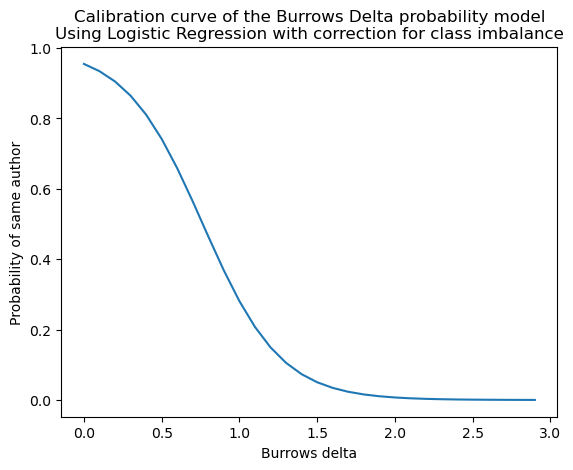

In [9]:
plt.plot(x_values, train_corpus.probability_model.predict_proba(np.reshape(x_values, (-1, 1)))[:,1])
plt.xlabel("Burrows delta")
plt.ylabel("Probability of same author")
plt.title("Calibration curve of the Burrows Delta probability model\nUsing Logistic Regression with correction for class imbalance")
;

# Plot the ROC curve

The ROC curve and the AUC metric are useful ways of measuring the performance of a classifier.

In our case the Burrows' Delta method, when used as a two-class text classifier (different author vs. same author), has an incredibly easy task, because it has learnt from entire books.

In [10]:
ground_truths, deltas = get_calibration_curve(train_corpus)

In [11]:
probabilities = train_corpus.probability_model.predict_proba(np.reshape(deltas, (-1, 1)))[:,1]

In [12]:
from sklearn.metrics import roc_curve, auc

In [13]:
fpr, tpr, thresholds = roc_curve(ground_truths, probabilities)

In [14]:
roc_auc = auc(fpr, tpr)

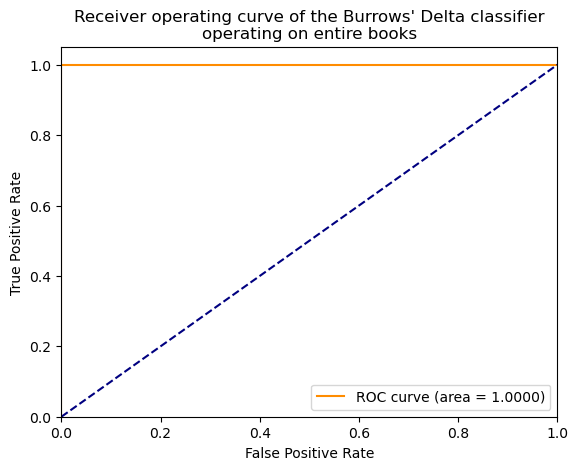

In [15]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating curve of the Burrows\' Delta classifier\noperating on entire books')
plt.legend(loc="lower right")
plt.show()

# Segment the corpus and display the various books in a scatter graph using PCA

Scatter graph shows books' stylistic similarities by placing similar books or segments close together in 2D space.

In [16]:
from sklearn.decomposition import PCA
import re
import pandas as pd

In [17]:
# Reload the training corpus as the "test corpus", re-tokenise it, and segment it this time
test_corpus = load_corpus_from_folder("data/train")
test_corpus.tokenise(tokenise_remove_pronouns_en)

In [18]:
split_test_corpus = test_corpus.split(80000)

In [19]:
df_delta = calculate_burrows_delta(train_corpus, split_test_corpus)

In [20]:
z_scores = split_test_corpus.author_z_scores

In [21]:
pca_model = PCA(n_components=2)

In [22]:
pca_matrix = pca_model.fit_transform(z_scores.T)

In [23]:
authors = split_test_corpus.authors

In [24]:
df_pca_by_author = pd.DataFrame(pca_matrix)
df_pca_by_author["author"] = authors

Text(0.5, 1.0, 'Representation using PCA of works in training corpus')

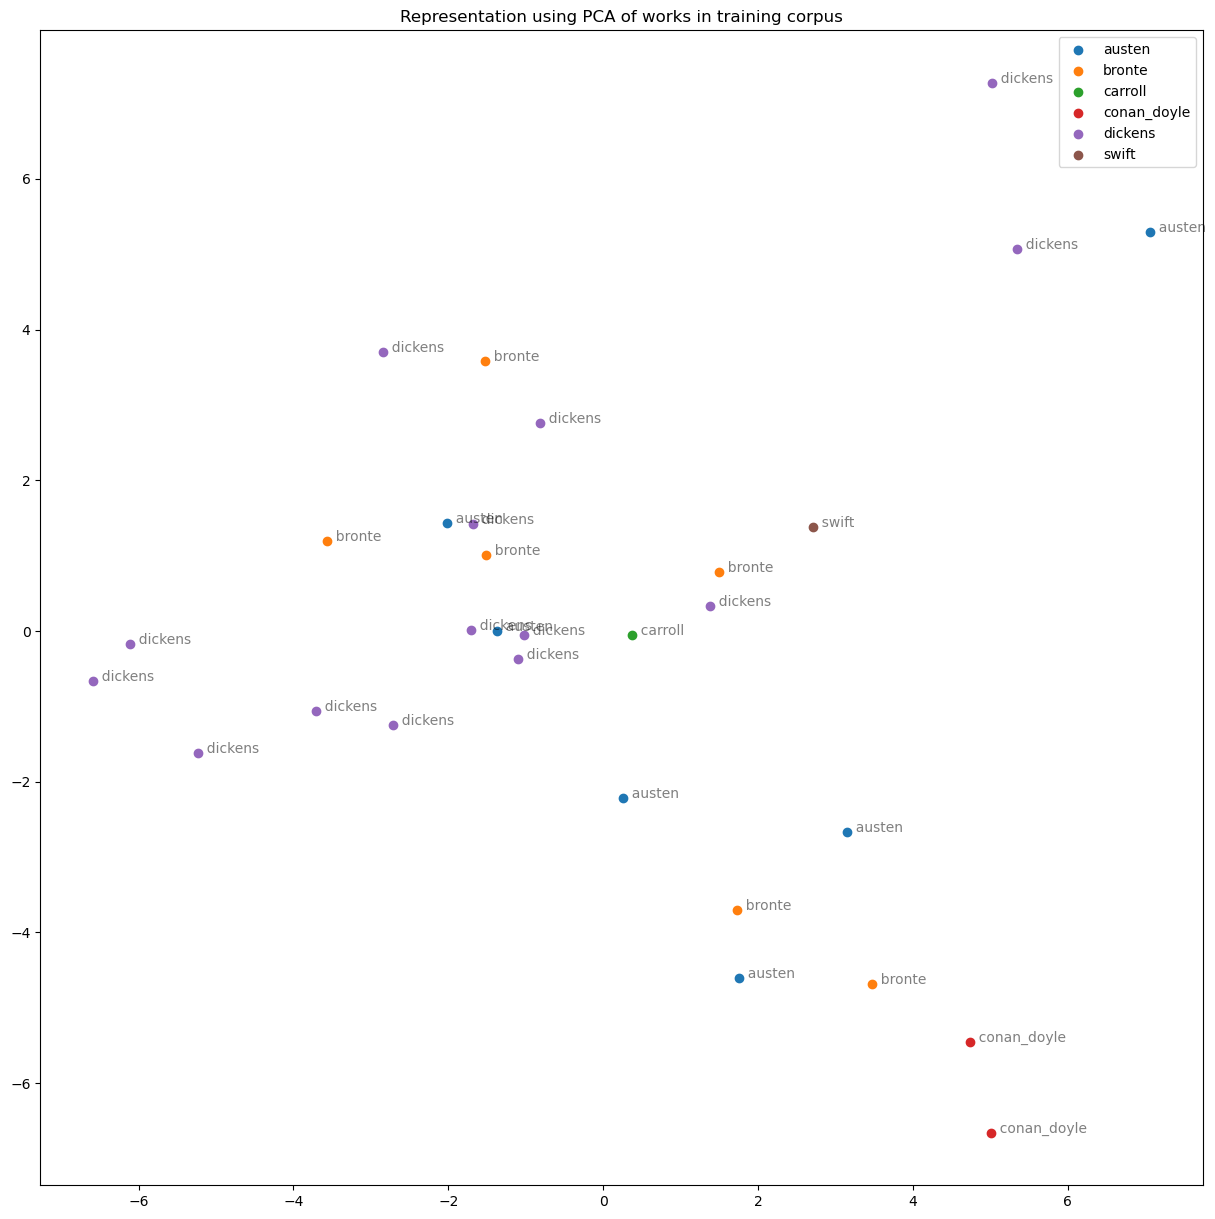

In [25]:
plt.figure(figsize=(15,15)) 

for author, pca_coordinates in df_pca_by_author.groupby("author"):
    plt.scatter(*zip(*pca_coordinates.drop("author", axis=1).to_numpy()), label=author)
for i in range(len(pca_matrix)):
    plt.text(pca_matrix[i][0], pca_matrix[i][1],"  " + authors[i], alpha=0.5)

plt.legend()

plt.title("Representation using PCA of works in training corpus")